In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
import nltk
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

         
from bs4 import BeautifulSoup  
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [80]:
#read the data set
dataset = pd.read_csv("dataset/news_summary.csv", encoding = "ISO-8859-1")

In [81]:
dataset.shape

(4514, 6)

In [82]:
dataset.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorcing rich man',http://www.hindustantimes.com/bollywood/malaika-arora-khan-was-trolled-for-divorcing-a-rich-man-her-reply-is-dignity-itself/story-oIPZNI9deImCmabLMMwR2H.html?utm_source=inshorts&utm_medium=referra...,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...","From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS' form,http://www.hindustantimes.com/patna/bihar-igims-form-loses-virginity-after-row-opts-for-unmarried-instead/story-8XmHIg39otGBoZAYEBQxMK.html?utm_source=inshorts&utm_medium=referral&utm_campaign=ful...,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...","The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec..."
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before being killed,http://indiatoday.intoday.in/story/abu-dujana-last-phone-call-lashkar-e-taiba-jammu-and-kashmir/1/1017550.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...","Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forc..."
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of sex trafficking,http://indiatoday.intoday.in/story/sex-trafficking-mumbai-rescue-me-maharashtra-international-labour-organization-forced-labour-trafficking-traning-hotel-staff/1/1017210.html?utm_source=inshorts&u...,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph...","Hotels in Mumbai and other Indian cities are to train their staff to spot signs of sex trafficking such as frequent requests for bed linen changes or a ""Do not disturb"" sign left on the door for d..."


In [83]:
#check the null cell if there are
dataset.isnull().sum()

author         0
date           0
headlines      0
read_more      0
text           0
ctext        118
dtype: int64

In [84]:
# del the null cells
dataset= dataset.dropna()
#del the unnecessary colums
dataset = dataset.drop(['author','date','headlines','read_more'],1)
dataset = dataset.reset_index(drop=True)

In [85]:
dataset.head()

,text,ctext
0,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...
1,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...","From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ..."
2,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...","The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec..."
3,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...","Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forc..."
4,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph...","Hotels in Mumbai and other Indian cities are to train their staff to spot signs of sex trafficking such as frequent requests for bed linen changes or a ""Do not disturb"" sign left on the door for d..."


In [86]:
# Now Inspecting our dataset for 5 texts
for i in range(5):
    print("Text #",i+1)
    print(dataset.ctext[i])
    print("Summary #",i+1)
    print(dataset.text[i])
    print()

Text # 1
The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by 

In [87]:
# We must prepering the our data now
# A list of contractions 
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [88]:
def cleanText(text, removeStopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        newText = []
        for word in text:
            if word in contractions:
                newText.append(contractions[word])
            else:
                newText.append(word)
        text = " ".join(newText)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if removeStopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text


In [89]:
nltk.download('stopwords')
  
# Clean the summaries and texts
clean_summaries = []
for summary in dataset.text:
    clean_summaries.append(cleanText(summary, removeStopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in dataset.ctext:
    clean_texts.append(cleanText(text))
print("Texts are complete.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Duzgun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Summaries are complete.
Texts are complete.


In [90]:
# Inspect the cleaned summaries and texts to ensure they have been cleaned well
for i in range(5):
    print("Clean Review #",i+1)
    print(clean_texts[i])
    print(clean_summaries[i])
    print()

Clean Review # 1
daman diu administration wednesday withdrew circular asked women staff tie rakhis male colleagues order triggered backlash employees ripped apart social media union territory administration forced retreat within 24 hours issuing circular made compulsory staff celebrate rakshabandhan workplace decided celebrate festival rakshabandhan august 7 connection offices departments shall remain open celebrate festival collectively suitable time wherein lady staff shall tie rakhis colleagues order issued august 1 gurpreet singh deputy secretary personnel said ensure one skipped office attendance report sent government next evening two notifications one mandating celebration rakshabandhan left withdrawing mandate right issued daman diu administration day apart circular withdrawn one line order issued late evening ut department personnel administrative reforms circular ridiculous sensitivities involved government dictate tie rakhi maintain professionalism workplace official told hi

In [91]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [92]:

# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

count_words(word_counts, clean_summaries)
count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 50459


In [93]:
clean_summaried =[]
start='_START_'
end = '_END_'
for i in range(0,len(clean_summaries)):
    clean_summaried.append(start +' '+ clean_summaries[i] + end)

In [94]:
clean_summaried[0]

'_START_ the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of rakshabandhan on august 7  the administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media _END_'

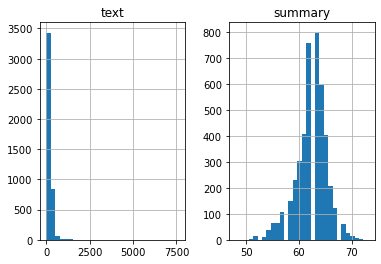

In [95]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in clean_texts:
      text_word_count.append(len(i.split()))

for i in clean_summaried:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [96]:
#Check how much % of summary have 0-65 words
cnt=0
for i in clean_summaried:
    if(len(i.split())<=68):
        cnt=cnt+1
print(cnt/len(clean_summaried))

0.9888535031847133


In [97]:
#Check how much % of text have 0-800 words
cnt=0
for i in clean_texts:
    if(len(i.split())<=800):
        cnt=cnt+1
print(cnt/len(clean_texts))

0.9886260236578708


In [98]:
max_text_length = 800
max_summary_length = 68

In [99]:
cleaned_texts=[]
cleaned_summaried=[]

for i in range(len(clean_texts)):
    if(len(clean_summaried[i].split())<=max_summary_length and len(clean_texts[i].split())<=max_text_length):
        cleaned_texts.append(clean_texts[i])
        cleaned_summaried.append(clean_summaried[i])

In [100]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(cleaned_texts,cleaned_summaried,test_size=0.2,random_state=0,shuffle=True) 


In [101]:
x_tr[0]

'varun dhawan alia bhatt frequenting sets various reality shows promote upcoming film badrinath ki dulhania recently varun wardrobe malfunction alia sets indian idol 9'

In [102]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_text_length, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_text_length, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [103]:
print(x_tr[0])

[ 1986  2815  2081  2153 15920  1649   379  1609   486  1528   909    25
  8588  1421  9295   296  1986 25199 12146  2081  1649    24  5875   448
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [104]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_summary_length, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_summary_length, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [105]:
from keras import backend as K 

K.clear_session()

latent_dim = 300
#embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_length,))

#embedding layer
enc_emb =  Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.4)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



#dense layer
#decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
#decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 800, 300)     12771000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 800, 300), ( 721200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [106]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [107]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [30]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=24, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
144/144 [==============================] - 1437s 10s/step - loss: 7.1445 - val_loss: 5.9472
Epoch 2/50
144/144 [==============================] - 1387s 10s/step - loss: 6.2820 - val_loss: 5.6576
Epoch 3/50
144/144 [==============================] - 1358s 9s/step - loss: 5.9043 - val_loss: 5.4422
Epoch 4/50
144/144 [==============================] - 1351s 9s/step - loss: 5.6478 - val_loss: 5.2950
Epoch 5/50
144/144 [==============================] - 1349s 9s/step - loss: 5.4570 - val_loss: 5.2170
Epoch 6/50
144/144 [==============================] - 1355s 9s/step - loss: 5.3133 - val_loss: 5.1666
Epoch 7/50
144/144 [==============================] - 1350s 9s/step - loss: 5.1520 - val_loss: 5.0926
Epoch 8/50
144/144 [==============================] - 1349s 9s/step - loss: 5.0374 - val_loss: 5.0392
Epoch 9/50
144/144 [==============================] - 1354s 9s/step - loss: 4.9191 - val_loss: 5.0179
Epoch 10/50
144/144 [==============================] - 1360s 9s/step - loss: 4.8

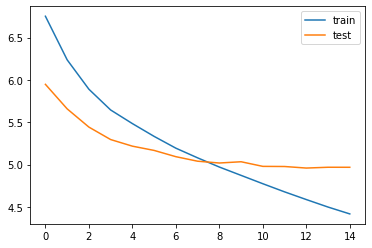

In [31]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [42]:
model.save('Saved_Model/mymodel')

INFO:tensorflow:Assets written to: Saved_Model/mymodel\assets
